[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sergey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


emotion
грусть       18430
злость       17305
радость      17099
удивление    15260
Name: count, dtype: int64
['радость' 'грусть' 'злость' 'удивление']
Epoch 1: Loss 1.3889
Epoch 2: Loss 1.3817
Epoch 3: Loss 1.3748
Epoch 4: Loss 1.3678
Epoch 5: Loss 1.3606
Epoch 6: Loss 1.3534
Epoch 7: Loss 1.3462
Epoch 8: Loss 1.3385
Epoch 9: Loss 1.3304
Epoch 10: Loss 1.3220
Epoch 11: Loss 1.3131
Epoch 12: Loss 1.3038
Epoch 13: Loss 1.2939
Epoch 14: Loss 1.2833
Epoch 15: Loss 1.2723
Epoch 16: Loss 1.2603
Epoch 17: Loss 1.2483
Epoch 18: Loss 1.2350
Epoch 19: Loss 1.2214
Epoch 20: Loss 1.2067


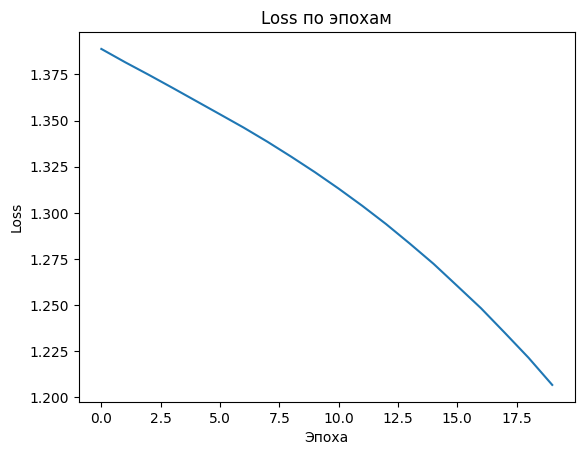

Точность: 0.9076597744360902
              precision    recall  f1-score   support

     радость       0.92      0.98      0.95      4275
      грусть       0.80      1.00      0.89      4608
      злость       0.99      1.00      1.00      4326
   удивление       1.00      0.60      0.75      3815

    accuracy                           0.91     17024
   macro avg       0.93      0.90      0.90     17024
weighted avg       0.92      0.91      0.90     17024

Пример:  радость


In [1]:
# train_mlp.ipynb

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import nltk
import re
import matplotlib.pyplot as plt

# Скачиваем стоп-слова
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('russian'))

# Функция предобработки
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

# Загружаем два датасета
df = pd.read_csv('data/ruemotext_sample1.csv', encoding='utf-8')
df = df.dropna(subset=['text', 'emotion'])
df = df[df['emotion'].isin(['радость', 'грусть', 'злость', 'удивление'])]
print(df['emotion'].value_counts())
print(df['emotion'].unique())
df['clean_text'] = df['text'].apply(preprocess)

# Маппинг эмоций
label2id = {e: i for i, e in enumerate(df['emotion'].unique())}
id2label = {i: e for e, i in label2id.items()}
df['label'] = df['emotion'].map(label2id)

# Векторизация TF-IDF
vectorizer = TfidfVectorizer(max_features=2000)
X = vectorizer.fit_transform(df['clean_text']).toarray()
y = df['label'].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Простая MLP-модель
class MLPClassifier(nn.Module):
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, n_classes)
        )
    def forward(self, x):
        return self.net(x)

model = MLPClassifier(X_train.shape[1], len(label2id))
optimizer = optim.Adam(model.parameters(), lr=0.002)
loss_fn = nn.CrossEntropyLoss()

# Обучение
losses = []
for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    out = model(X_train)
    loss = loss_fn(out, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch+1}: Loss {loss.item():.4f}")

# График лосса
plt.plot(losses)
plt.title('Loss по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.show()

# Оценка
model.eval()
with torch.no_grad():
    logits = model(X_test)
    preds = logits.argmax(dim=1).numpy()
    print('Точность:', accuracy_score(y_test, preds))
    print(classification_report(y_test, preds, target_names=[id2label[i] for i in range(len(id2label))]))

# Пример: предсказать эмоцию для нового текста
def predict(text):
    txt = preprocess(text)
    vec = vectorizer.transform([txt]).toarray()
    with torch.no_grad():
        pred = model(torch.tensor(vec, dtype=torch.float32))
        label_id = pred.argmax(dim=1).item()
        return id2label[label_id]

print("Пример: ", predict("Сегодня погода ужасная, настроение грустное"))